🇭 🇪 🇱 🇱 🇴 👋

This example shows how to use `segmentation-models-pytorch` for **binary** semantic segmentation. We will use the [The Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) (this is an adopted example from Albumentations package [docs](https://albumentations.ai/docs/examples/pytorch_semantic_segmentation/), which is strongly recommended to read, especially if you never used this package for augmentations before). 

The task will be to classify each pixel of an input image either as pet 🐶🐱 or as a background.


What we are going to overview in this example:  

 - 📜 `Datasets` and `DataLoaders` preparation (with predefined dataset class).  
 - 📦 `LightningModule` preparation: defining training, validation and test routines.  
 - 📈 Writing `IoU` metric inside the `LightningModule` for measuring quality of segmentation.  
 - 🐶 Results visualization.


> It is expected you are familiar with Python, PyTorch and have some experience with training neural networks before!

In [1]:
# !pip install segmentation-models-pytorch
# !pip install pytorch-lightning==1.5.4

In [2]:
# !pip install matplotlib seaborn

In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torchvision.transforms as transforms
import albumentations as A


from pprint import pprint
from torch.utils.data import DataLoader

## Dataset

In this example we will use predefined `Dataset` class for simplicity. The dataset actually read pairs of images and masks from disk and return `sample` - dictionary with keys `image`, `mask` and others (not relevant for this example).

⚠️ **Dataset preparation checklist** ⚠️

In case you writing your own dataset, please, make sure that:

1.   **Images** 🖼  
    ✅   Images from dataset have **the same size**, required for packing images to a batch.  
    ✅   Images height and width are **divisible by 32**. This step is important for segmentation, because almost all models have skip-connections between encoder and decoder and all encoders have 5 downsampling stages (2 ^ 5 = 32). Very likely you will face with error when model will try to concatenate encoder and decoder features if height or width is not divisible by 32.  
    ✅   Images have **correct axes order**. PyTorch works with CHW order, we read images in HWC [height, width, channels], don`t forget to transpose image.
2.   **Masks** 🔳  
    ✅   Masks have **the same sizes** as images.   
    ✅   Masks have only `0` - background and `1` - target class values (for binary segmentation).  
    ✅   Even if mask don`t have channels, you need it. Convert each mask from **HW to 1HW** format for binary segmentation (expand the first dimension).

Some of these checks are included in LightningModule below during the training.

❗️ And the main rule: your train, validation and test sets are not intersects with each other!

In [2]:
from brightfield import BrightfieldDataset

In [3]:
root = "../../data/"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# transform = transforms.Compose(
#     [transforms.Resize((256,256)),     
#      transforms.ToTensor(),
#      transforms.ConvertImageDtype(torch.float32),
#     ])

transform = A.Compose([
    A.Flip(p=0.5),
    A.RandomRotate90(p=0.5),
#     A.GaussianBlur(p=0.5), #this is causing the image to became all ones
#     A.RandomBrightnessContrast(contrast_limit=0.2, p=0.5),
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True),
    ])

transform_val = A.Compose([
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True),
    ])

transform_test = A.Compose([
    A.RandomCrop(height=320, width=320, always_apply=True, p=1),
    A.Resize(height=256, width=256, always_apply=True)])

In [5]:
BATCH_SIZE = 16

In [6]:
split_file = "../../baseline_images_stratified.csv"
train_dataset = BrightfieldDataset(root, "train", split_file=split_file, transform=transform)
valid_dataset = BrightfieldDataset(root, "val", split_file=split_file, transform=transform_val)
test_dataset = BrightfieldDataset(root, "test", split_file=split_file, transform=transform_test)

# It is a good practice to check datasets don`t intersects with each other
assert set(test_dataset.filenames).isdisjoint(set(train_dataset.filenames))
assert set(test_dataset.filenames).isdisjoint(set(valid_dataset.filenames))
assert set(train_dataset.filenames).isdisjoint(set(valid_dataset.filenames))

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Test size: {len(test_dataset)}")

n_cpu = os.cpu_count()
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=n_cpu)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=n_cpu)

Train size: 2016
Valid size: 504
Test size: 504


(1, 256, 256) (1, 256, 256)


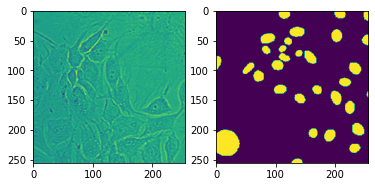

(1, 256, 256) (1, 256, 256)


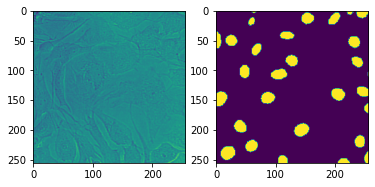

(1, 256, 256) (1, 256, 256)


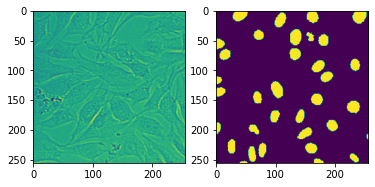

In [7]:
# lets look at some samples

sample = train_dataset[0]
print(sample["image"].shape, sample["mask"].shape)
plt.subplot(1,2,1)
plt.imshow(sample["image"].squeeze()) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
print(sample["image"].shape, sample["mask"].shape)
plt.subplot(1,2,1)
plt.imshow(sample["image"].squeeze()) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
print(sample["image"].shape, sample["mask"].shape)
plt.subplot(1,2,1)
plt.imshow(sample["image"].squeeze()) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()

## Model

In [8]:
# import timm
# timm.models.registry._model_has_pretrained
# smp.encoders.get_preprocessing_params("tu-vit_base_patch16_224")

In [9]:
smp.encoders.get_preprocessing_params("resnet34")

{'input_space': 'RGB',
 'input_range': [0, 1],
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225]}

In [10]:
from functional import *
class PetModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params("resnet34")
        # mean and std calculated over all training images
        params["mean"] = [[[5388.582166338724]]]
        params["std"] = [[[530.4326381777722]]]
        self.register_buffer("std", torch.tensor(params["std"]))
        self.register_buffer("mean", torch.tensor(params["mean"]))

        # for image segmentation dice loss could be the best first choice
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)

    def forward(self, image):
        # normalize image here
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32); e.g. if we have image with shape 65x65 we will have 
        # following shapes of features in encoder and decoder: 84, 42, 21, 10, 5 -> 5, 10, 20, 40, 80
        # and we will get an error trying to concat these features
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes, height, width]
        # for binary segmentation num_classes = 1
        assert mask.ndim == 4

        # Check that mask values in between 0 and 1, NOT 0 and 255 for binary segmentation
        assert mask.max() <= 1.0 and mask.min() >= 0

        logits_mask = self.forward(image)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_mask, mask)

        # Lets compute metrics for some threshold
        # first convert mask values to probabilities, then 
        # apply thresholding
        prob_mask = logits_mask.sigmoid()
        pred_mask = (prob_mask > 0.5).float()

        # We will compute IoU metric by two ways
        #   1. dataset-wise
        #   2. image-wise
        # but for now we just compute true positive, false positive, false negative and
        # true negative 'pixels' for each image and class
        # these values will be aggregated in the end of an epoch
        tp, fp, fn, tn = get_stats(pred_mask.long(), mask.long(), mode="binary")

        return {
            "loss": loss,
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        }

    def shared_epoch_end(self, outputs, stage):
        # aggregate step metics
        tp = torch.cat([x["tp"] for x in outputs])
        fp = torch.cat([x["fp"] for x in outputs])
        fn = torch.cat([x["fn"] for x in outputs])
        tn = torch.cat([x["tn"] for x in outputs])

        # per image IoU means that we first calculate IoU score for each image 
        # and then compute mean over these scores
        per_image_iou = iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
        
        # dataset IoU means that we aggregate intersection and union over whole dataset
        # and then compute IoU score. The difference between dataset_iou and per_image_iou scores
        # in this particular case will not be much, however for dataset 
        # with "empty" images (images without target class) a large gap could be observed. 
        # Empty images influence a lot on per_image_iou and much less on dataset_iou.
        dataset_iou = iou_score(tp, fp, fn, tn, reduction="micro")

        metrics = {
            f"{stage}_per_image_iou": per_image_iou,
            f"{stage}_dataset_iou": dataset_iou,
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, "train")            

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, "valid")

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        return self.shared_step(batch, "test")  

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [11]:
# model = PetModel("UNet", "tu-botnet26t_256", in_channels=1, out_classes=1)
model = PetModel("UNet", "resnet34", in_channels=1, out_classes=1)

## Training

In [12]:
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger

checkpointer = ModelCheckpoint(
#     dirpath='checkpoints/tu-botnet26t_256/',
    dirpath='checkpoints/resnet34-aug/',
    filename='{epoch}-{val_loss:.2f}-{valid_dataset_iou:.2f}'
)
early_stopping = EarlyStopping('valid_dataset_iou', mode='max', patience=20, verbose=True)

trainer = pl.Trainer(
    gpus=1, 
    accelerator='auto',
    devices=device,
    max_epochs=300,
    callbacks=[TQDMProgressBar(refresh_rate=10), checkpointer, early_stopping],
    logger=CSVLogger(save_dir="logs-resnet/"),
    resume_from_checkpoint='checkpoints/resnet34-aug/epoch=230-val_loss=0.00-valid_dataset_iou=0.67.ckpt'
)

/home/braian/anaconda3/envs/mt-proj/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:46: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  "Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [15]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
    val_dataloaders=valid_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 24.4 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.720    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved. New best score: 0.159


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.169


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.018 >= min_delta = 0.0. New best score: 0.188


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.025 >= min_delta = 0.0. New best score: 0.212


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.043 >= min_delta = 0.0. New best score: 0.256


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.033 >= min_delta = 0.0. New best score: 0.289


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.040 >= min_delta = 0.0. New best score: 0.329


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.036 >= min_delta = 0.0. New best score: 0.365


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.036 >= min_delta = 0.0. New best score: 0.401


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.021 >= min_delta = 0.0. New best score: 0.422


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.437


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.022 >= min_delta = 0.0. New best score: 0.459


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.467


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.006 >= min_delta = 0.0. New best score: 0.473


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.015 >= min_delta = 0.0. New best score: 0.488


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.011 >= min_delta = 0.0. New best score: 0.499


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.506


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.511


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.515


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.010 >= min_delta = 0.0. New best score: 0.526


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.009 >= min_delta = 0.0. New best score: 0.535


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.536


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.544


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.549


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.551


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.555


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.556


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.564


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.568


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.008 >= min_delta = 0.0. New best score: 0.576


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.580


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.584


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.588


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.590


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.595


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.597


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.598


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.005 >= min_delta = 0.0. New best score: 0.602


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.604


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.608


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.007 >= min_delta = 0.0. New best score: 0.615


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.615


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.617


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.618


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.620


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.620


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.624


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.625


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.626


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.628


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.631


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.631


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.635


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.638


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.640


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.640


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.643


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.644


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.646


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.647


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.648


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.651


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.652


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.655


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.656


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.657


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.658


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.661


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.664


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.664


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.665


Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.003 >= min_delta = 0.0. New best score: 0.668


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.669


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.002 >= min_delta = 0.0. New best score: 0.671


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.000 >= min_delta = 0.0. New best score: 0.671


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.001 >= min_delta = 0.0. New best score: 0.672


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric valid_dataset_iou improved by 0.004 >= min_delta = 0.0. New best score: 0.676


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric valid_dataset_iou did not improve in the last 20 records. Best score: 0.676. Signaling Trainer to stop.


In [72]:
metrics = pd.DataFrame()
versions = os.listdir("logs-resnet/default/")
for version in versions:
    if os.path.exists(f"logs-resnet/default/{version}/metrics.csv"):
        metrics = pd.concat([metrics, pd.read_csv(f"logs-resnet/default/{version}/metrics.csv")])

,valid_per_image_iou,valid_dataset_iou,train_per_image_iou,train_dataset_iou
epoch,,,,
230,NaN,NaN,NaN,NaN
230,0.693594,0.675043,NaN,NaN
230,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN
0,0.132358,0.132358,NaN,NaN


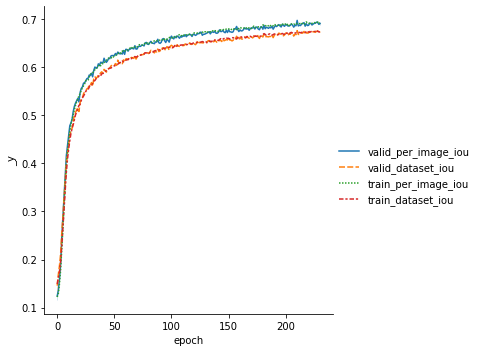

In [73]:
# metrics = pd.read_csv(f"logs-resnet/default/version_0/metrics.csv")
#drop test metrics because they are not available
metrics = metrics.drop(columns=["test_per_image_iou", "test_dataset_iou"])
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").tail())
sns.relplot(data=metrics, kind="line")

## Validation and test metrics

In [13]:
# checkpoint = torch.load()
# model.load_state_dict(checkpoint['model'])
model = PetModel.load_from_checkpoint("checkpoints/resnet34-aug/epoch=230-val_loss=0.00-valid_dataset_iou=0.67.ckpt",
                                      arch="UNet", encoder_name="resnet34", in_channels=1, out_classes=1)

In [14]:
# run validation dataset
trainer = pl.Trainer(gpus=1, 
                     accelerator='auto',
                     devices=device,)
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.6743389368057251,
  'valid_per_image_iou': 0.688545286655426}]


In [31]:
# run validation dataset
trainer = pl.Trainer(gpus=1, 
                     accelerator='auto',
                     devices=device,)
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validating: 0it [00:00, ?it/s]

[{'valid_dataset_iou': 0.6734112501144409,
  'valid_per_image_iou': 0.6930940747261047}]


# Result visualization

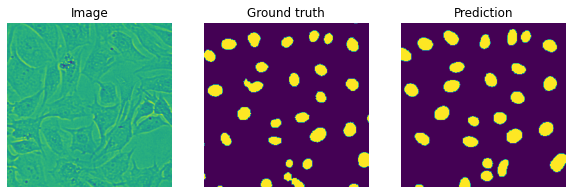

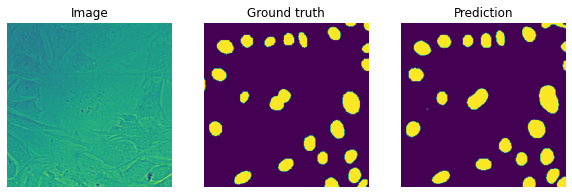

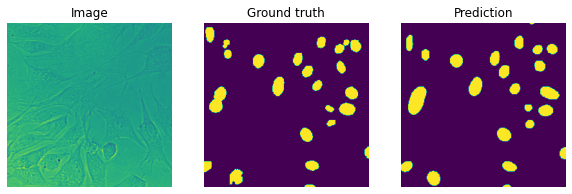

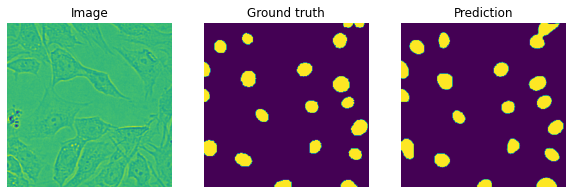

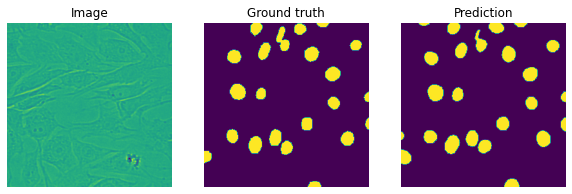

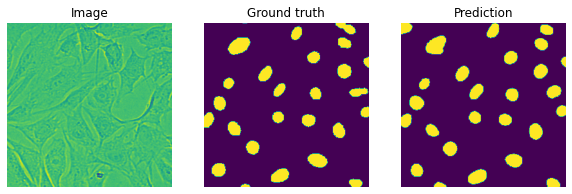

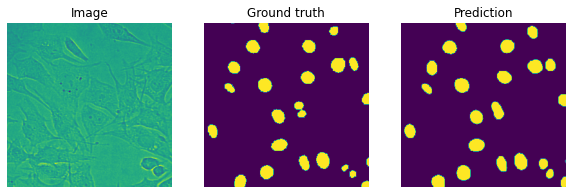

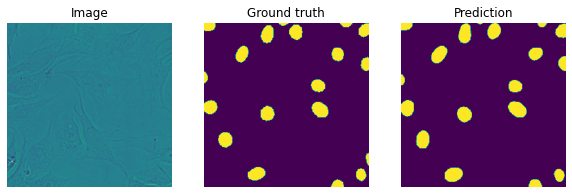

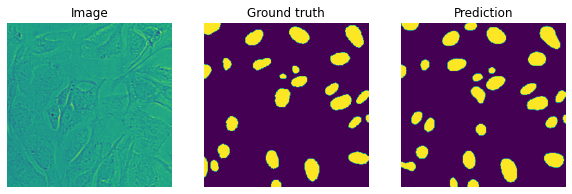

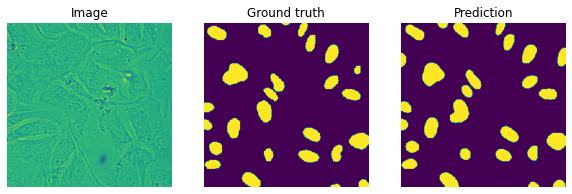

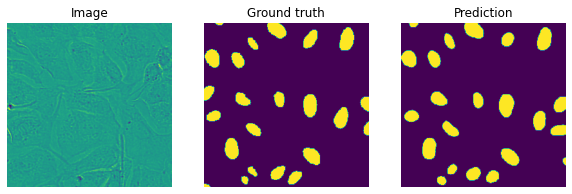

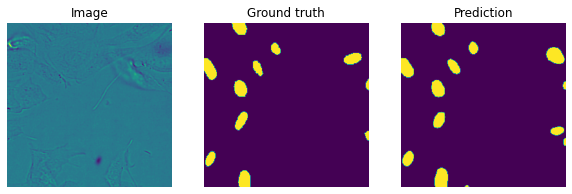

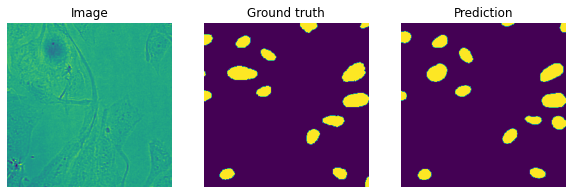

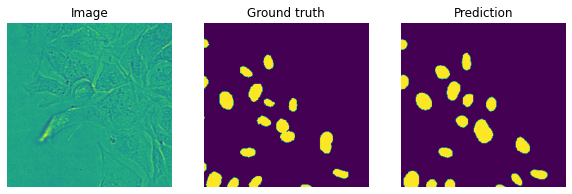

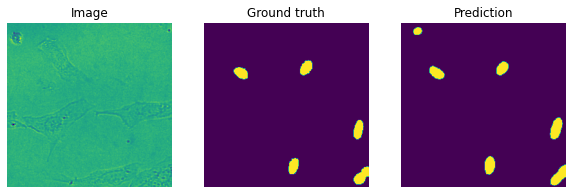

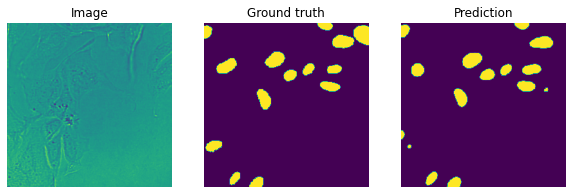

In [43]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()

## Model evaluation

In [15]:
split = pd.read_csv("../../baseline_images_stratified.csv")
test_split = split[split["set"]=='test']

In [29]:
image_filename = test_split.bf.values[0]
image_path = os.path.join(root, "images", image_filename[image_filename.rfind("/")+1:])
mask_filename = test_split.stencil.values[0]
mask_path = os.path.join(root, "complete_stencils", mask_filename[mask_filename.rfind("/")+1:])
image = np.array(Image.open(image_path), dtype=np.uint16)
image = np.moveaxis(image, -1, 0)
image = np.expand_dims(image, 0)         
print(image.shape)
mask = np.array(Image.open(mask_path), dtype=np.uint16)
mask = np.expand_dims(mask, 0)
print(mask.shape)

(1, 1080, 1080)
(1, 1080, 1080)


In [53]:
import cv2

def split_image_into_patches(image, num_patches, resize=(256,256)):
#     if resize:
#         im_patch_size = resize[0]
#     else:
    im_patch_size = int(image.shape[1] // np.sqrt(num_patches))
    out_image = np.zeros((num_patches, 1, resize[0], resize[1]), dtype=np.uint16)
    row = 0
    col = 0

    for i in range(num_patches):
    #     print(row, col)
#         print(f"{row * im_patch_size}:{row * im_patch_size + im_patch_size}, {col * im_patch_size}:{col * im_patch_size + im_patch_size}")
        patch = image[0, row * im_patch_size:row * im_patch_size + im_patch_size, col * im_patch_size:col * im_patch_size + im_patch_size] 
        if resize:
            patch = cv2.resize(patch, resize, cv2.INTER_LINEAR)
        out_image[i,0,:,:] = patch
        col += 1
        if col >= np.sqrt(num_patches):
            row += 1
            col = 0
            
    return out_image

def reconstruct_image(image_patches, resize=(270, 270)):
    if resize:
        im_patch_size = resize[0]
    else:
        im_patch_size = image_patches.shape[2]
    num_patches = image_patches.shape[0]
    im_size = int(np.sqrt(num_patches) * im_patch_size)
    rec_image = np.zeros((1, im_size, im_size), dtype=np.uint16)
    print(rec_image.shape)
    row = 0
    col = 0    
    
    for i in range(num_patches):
#         print(row, col)
#         print(f"{row * im_patch_size}:{row * im_patch_size + im_patch_size}, {col * im_patch_size}:{col * im_patch_size + im_patch_size}")
        patch = image_patches[i]
        if resize:
            patch = cv2.resize(patch.squeeze(), resize, cv2.INTER_LINEAR)
        rec_image[0, row * im_patch_size:row * im_patch_size + im_patch_size, col * im_patch_size:col * im_patch_size + im_patch_size] = patch
        col += 1
        if col >= np.sqrt(num_patches):
            row += 1
            col = 0
            
    return rec_image

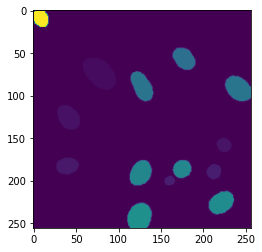

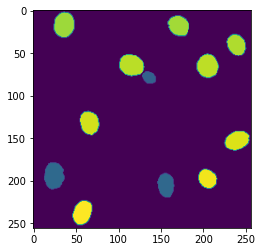

In [54]:
image_patches = split_image_into_patches(mask, 16)
plt.imshow(image_patches[0].squeeze())
plt.show()
plt.imshow(image_patches[15].squeeze())
plt.show()

(1, 1080, 1080)


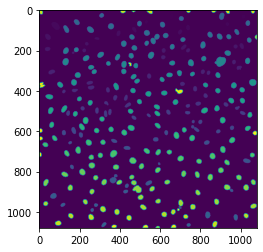

In [55]:
plt.imshow(reconstruct_image(image_patches).squeeze())

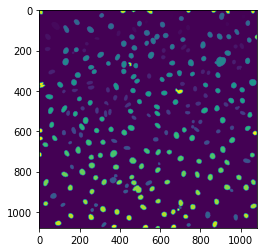

In [56]:
plt.imshow(mask.squeeze())

torch.Size([16, 1, 256, 256])


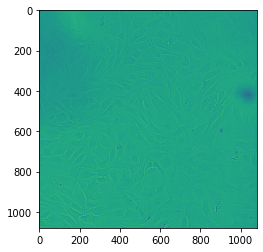

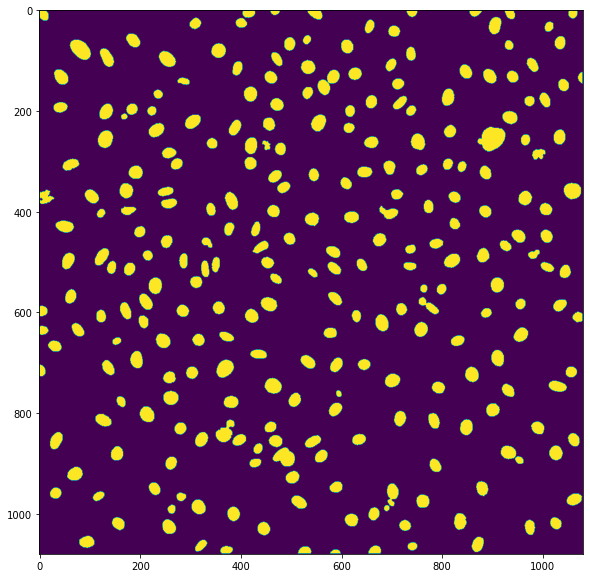

(1, 1080, 1080)


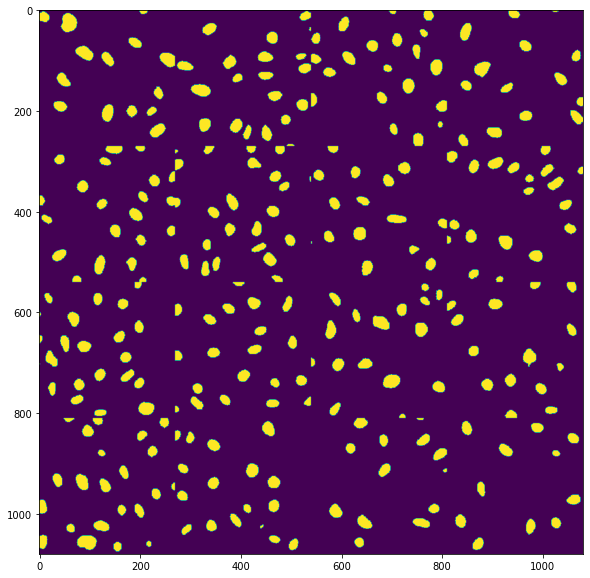

In [67]:
for idx, row in test_split.iterrows():
    image_filename = row['bf']
    image_path = os.path.join(root, "images", image_filename[image_filename.rfind("/")+1:])
    mask_filename = row['stencil']
    mask_path = os.path.join(root, "complete_stencils", mask_filename[mask_filename.rfind("/")+1:])
    
    image = np.array(Image.open(image_path), dtype=np.uint16)
    image = np.moveaxis(image, -1, 0)
    image = np.expand_dims(image, 0)         
    mask = np.array(Image.open(mask_path), dtype=np.uint16)
    mask[mask>0] = 1
    mask = np.expand_dims(mask, 0)
    
    image_patches = split_image_into_patches(image, 16)
    input_ = torch.tensor(image_patches.astype(np.float32))
    print(input_.shape)
    with torch.no_grad():
        model.eval()
        logits = model(input_)
    pr_masks = logits.sigmoid()
    
    plt.imshow(image.squeeze())
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(mask.squeeze())
    plt.show()
    plt.figure(figsize=(10,10))
    plt.imshow(reconstruct_image(pr_masks.numpy()).squeeze())
    plt.show()
    break
    
#     for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
#     plt.figure(figsize=(10, 5))

#     plt.subplot(1, 3, 1)
#     plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
#     plt.title("Image")
#     plt.axis("off")

#     plt.subplot(1, 3, 2)
#     plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Ground truth")
#     plt.axis("off")

#     plt.subplot(1, 3, 3)
#     plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
#     plt.title("Prediction")
#     plt.axis("off")

#     plt.show()

In [18]:
assert 1==0, ""

AssertionError: 

# Result visualization (demo cats and dogs)

In [ ]:
batch = next(iter(test_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gt_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()